#  Increasing trend Time Series Analysis - M3C dataset, monthly industry ts N2184


In [1]:
# ETL libraries
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import psycopg2
from dateutil.relativedelta import relativedelta # working with dates with style

# visualization
import matplotlib.pyplot as plt

# modeling
# grid search simple forecasts
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR, ARResults
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose 
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SARIMAX

# TES 
from scipy.optimize import minimize              # for function minimization
from sklearn.model_selection import TimeSeriesSplit


# Error measures
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


# ready made module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# classical models: Naive, ETS, SARIMAX
import classical_models_univariate as cmu
# import simple_configs, exp_smoothing_configs, sarima_configs, grid_search, sarima_plot, ets_plot

# Neural Networks models
import neural_networks_univariate as nnu
# import repeat_evaluate, summarize_scores, grid_search, grid_search_repeat_evaluate, cnn_configs



Using TensorFlow backend.


## Functions



In [2]:
# we use sqlalchemy to load the data to Postgres
engine = create_engine('postgresql+psycopg2://{}:{}@{}:{}/postgres' \
    .format('manfredi', # username
            'manfredi', # password
            'localhost', # host
            '5432' # local port
           ) 
    , echo=False)

# quick function to pull data from the postgres engine
def pull_data(sql):
    """
    This function pull the data from our Postgres accepts a sql query
    """
    df = pd.read_sql(sql, con=engine)
    return df

# visualization
# here we visualize the line plot. Each observation is an observation at the next year (this is an assumption)
def line_viz(data, title):
    plt.figure(figsize=(15, 7))
    plt.plot(data, color = 'black')
    plt.scatter(data.index, data[0], alpha = 0.3, marker = 'o', color = 'red')
    plt.title(str(title))
    # plt.grid(True)
    # limiting the Y-axis for visual purposes
    # plt.ylim((50000, 1000000))
    # You can specify a rotation for the tick labels in degrees or with keywords.
    plt.xticks( rotation='90')
    plt.show()
    
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

## Data load and EDA

In [3]:
# pull one single time series of category finance
df_n2181 = pull_data(
"""
SELECT 
    * 
FROM 
    public.m3c_time_series_months 
WHERE
     series ILIKE 'N2184'
"""
              )

df_n2181 = df_n2181.T.iloc[4:-2, :].astype(float).iloc[1:].dropna()



### Line plots

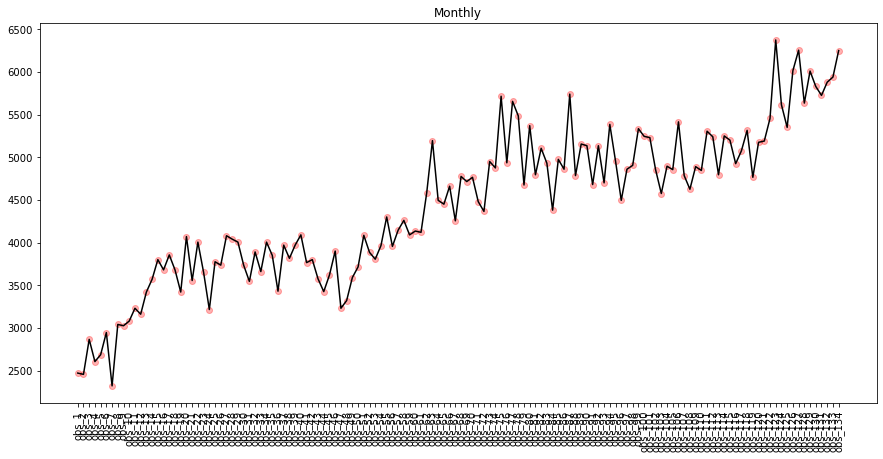

In [4]:
line_viz(df_n2181, "Monthly")

We can see a sligh increasing trend and some cyclical trends

### Seasonal plots

In [5]:
# split the ts in years to plot separately. 
seasonals = [df_n2181[x:x+12] for x in range(0, len(df_n2181),12)]


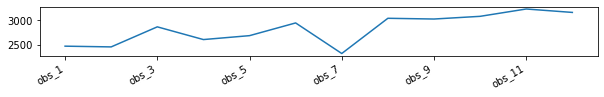

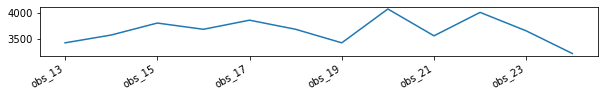

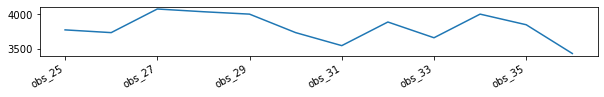

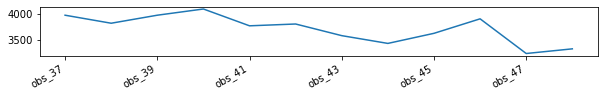

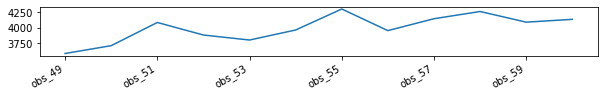

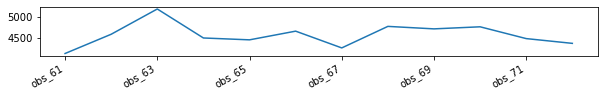

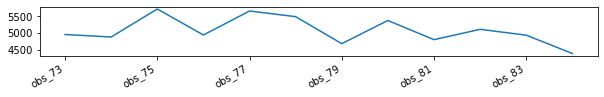

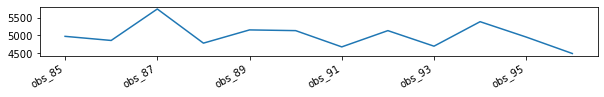

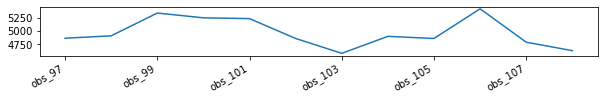

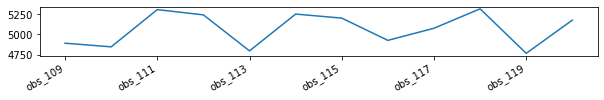

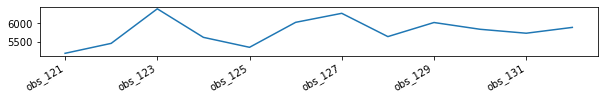

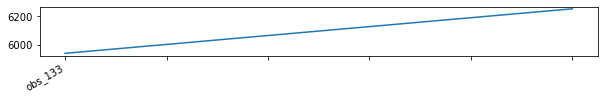

In [6]:
for i, val in enumerate(seasonals):
    seasonals[i].plot(subplots=True, legend=False, figsize=(10,1)) 
    plt.show()

There are no clear trends Year over year. Maybe one at observation 3

### Distribution

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

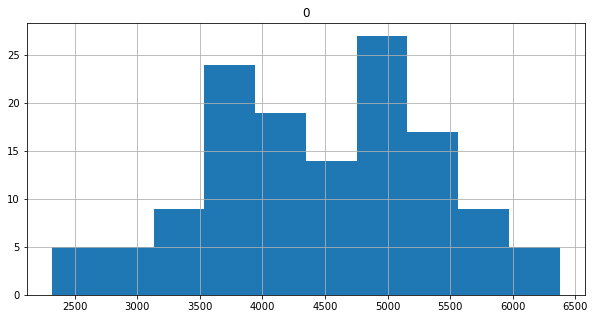

In [7]:
df_n2181.hist(figsize = (10, 5))

<AxesSubplot:ylabel='Density'>

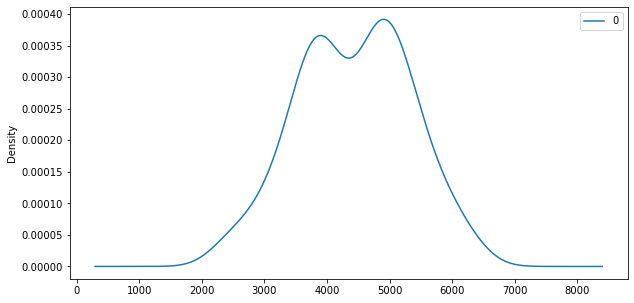

In [8]:
df_n2181.plot(kind = 'kde', figsize = (10, 5))

The distribution looks double Gaussian but centered

### Box-Whisker Plot

We avoid to plot the Box-Whisker plot

### ACF and PACF, study of differentiation and seasonalities

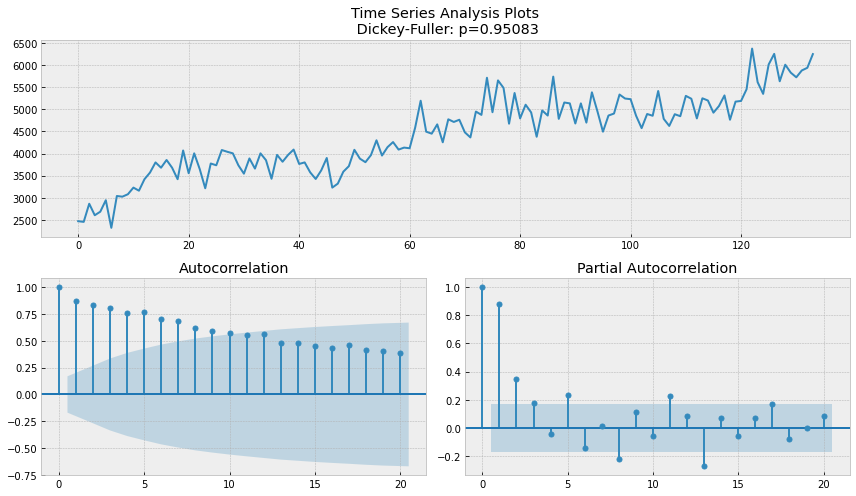

In [9]:
tsplot(list(df_n2181[0].dropna()), lags=20)

The original time series is not stationary. It is hard to evaluate seasonal cycles but from the PACF chart we see non null lags at observation 3

## Modeling - Simple modeling

In [10]:


# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.5)
# model configs
max_length = len(data) - n_test
# seasonality can be added to the simple model by using the offset list parameter
simple_cfg_list = cmu.simple_configs(max_length, [0,3])
# grid search
scores = cmu.grid_search(data, simple_cfg_list, n_test, model_type = 'simple', measure_type = 'rmse')
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[1, 0, 'persist']] 450.626
 > Model[[1, 3, 'persist']] 450.626
 > Model[[3, 0, 'persist']] 466.254 > Model[[2, 0, 'persist']] 446.721 > Model[[2, 3, 'median']] 441.251 > Model[[2, 3, 'persist']] 446.721 > Model[[2, 0, 'mean']] 2732.541 > Model[[2, 0, 'median']] 2732.541 > Model[[2, 3, 'mean']] 441.251






 > Model[[3, 0, 'mean']] 2732.541 > Model[[4, 0, 'persist']] 511.319 > Model[[3, 3, 'persist']] 466.254 > Model[[3, 3, 'mean']] 437.563 > Model[[5, 0, 'persist']] 444.542 > Model[[3, 0, 'median']] 2732.541 > Model[[4, 0, 'median']] 2732.541 > Model[[4, 3, 'mean']] 407.483







 > Model[[6, 0, 'persist']] 530.223 > Model[[5, 0, 'mean']] 2732.541 > Model[[4, 0, 'mean']] 2732.541 > Model[[5, 3, 'mean']] 442.632 > Model[[5, 0, 'median']] 2732.541 > Model[[3, 3, 'median']] 468.995 > Model[[4, 3, 'persist']] 511.319



 > Model[[6, 0, 'mean']] 2732.541


 > Model[[4, 3, 'median']] 431.667 > Model[[5, 3, 'persist']] 444.542
 > Model[[7, 0, 'persist']] 495.609
 > Model[[6, 0, 'me

As expected, the model suggest a mean model with 4 differencing lag and 3 seasonal lags

## Modeling - Exponential triple smoothing

In [11]:
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.5)
# model configs
# max_length = len(data) - n_test
# simple_cfg_list = simple_configs(max_length, [0,3])
exp_cfg_list = cmu.exp_smoothing_configs([0,1])
# grid search
scores = cmu.grid_search(data[:, 0], exp_cfg_list, n_test, model_type = 'ets', measure_type = 'rmse')
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[['add', False, None, 1, False, True]] 368.966
 > Model[['add', True, None, 1, False, True]] 370.254
 > Model[['add', True, None, 0, False, True]] 370.254
 > Model[['add', False, None, 0, False, True]] 368.966
 > Model[['add', False, None, 0, True, True]] 361.121 > Model[['add', False, None, 1, True, True]] 361.121

 > Model[['add', True, None, 1, True, True]] 358.522
 > Model[['add', True, None, 0, True, True]] 358.522
 > Model[['add', False, None, 1, False, False]] 366.972
 > Model[['add', False, None, 0, False, False]] 366.972
 > Model[['add', True, None, 1, False, False]] 369.534
 > Model[['add', True, None, 0, False, False]] 369.534
 > Model[['add', False, None, 1, True, False]] 366.310
 > Model[['add', False, None, 0, True, False]] 366.310
 > Model[['add', True, None, 0, True, False]] 361.700
 > Model[['add', True, None, 1, True, False]] 361.700
 > Model[[None, False, None, 0, False, True]] 366.692
 > Model[[None, False, None, 0, True, True]] 366.708
 > Model[[None, False

Modelling the Triple exponential smoothing suggests that the best fit is achieved using: 
- Additive trend
- Where the trend is damped
- No seasonality
- 0 seasonal periods 
- Box Cox transformed 
- Bias corrected

ETS top 3 performers outperforms simple models

In [12]:
# https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html
# index= pd.date_range(start='1947', end=str(1947+round(len(df_n2181)/12)), freq='M')
# data = pd.Series(list(df_n2181[0]), df_n2181.index)


In [13]:

# fit = ExponentialSmoothing(data, trend='additive', damped_trend=True, seasonal=None, seasonal_periods=0, use_boxcox=True, initialization_method="estimated").fit()
# simulations = fit.simulate(20, repetitions=100, error='mul')

# ax = data.plot(figsize=(15,10), marker='o', color='black',
#                title="Forecasts and simulations from Holt-Winters'" )
# ax.set_ylabel("International visitor night in Australia (millions)")
# ax.set_xlabel("Year")
# fit.fittedvalues.plot(ax=ax, style='--', color='green')
# simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', legend=False)
# fit.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='o', color='green', legend=True)
# plt.show()

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  134
Model:             ExponentialSmoothing   SSE                       13613561.165
Optimized:                         True   AIC                           1554.851
Trend:                         Additive   BIC                           1569.340
Seasonal:                          None   AICC                          1555.740
Seasonal Periods:                  None   Date:                 Wed, 10 Mar 2021
Box-Cox:                           True   Time:                         15:35:39
Box-Cox Coeff.:                 1.12503                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3114286                alpha                 True
smoothing_trend               0.00

/Users/manfredi/miniconda3/envs/ds/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


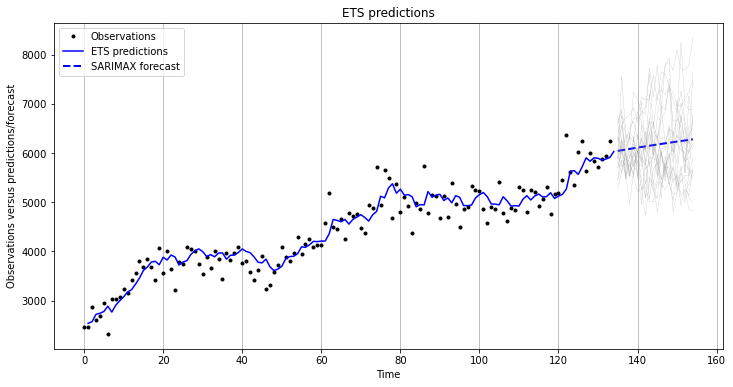

In [12]:
config = ['additive', True, None, 0, True, "estimated"]
n_sim = 20

cmu.ets_plot(data, config, 20, 20)    

## Modeling - SARIMAX

In [17]:
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.5)
# model configs
cfg_list = cmu.sarima_configs()
# grid search
scores = cmu.grid_search(data, cfg_list, n_test, model_type = 'sarimax', measure_type = 'rmse',  parallel=True)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

 > Model[[(0, 0, 0), (0, 0, 0, 0), 'n']] 5183.265
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'c']] 1128.732
 > Model[[(0, 0, 0), (0, 0, 0, 0), 't']] 1630.094
 > Model[[(0, 0, 0), (0, 0, 0, 0), 'ct']] 416.624
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'n']] 2690.534
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'n']] 450.626
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'c']] 742.643
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'c']] 452.124
 > Model[[(0, 1, 0), (0, 0, 0, 0), 't']] 456.995
 > Model[[(0, 1, 0), (0, 0, 0, 0), 'ct']] 459.938
 > Model[[(0, 0, 1), (0, 0, 0, 0), 't']] 984.341
 > Model[[(0, 0, 2), (0, 0, 0, 0), 'c']] 628.702
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'n']] 369.473
 > Model[[(0, 0, 1), (0, 0, 0, 0), 'ct']] 399.474
 > Model[[(0, 0, 2), (0, 0, 0, 0), 'n']] 1775.140
 > Model[[(0, 1, 2), (0, 0, 0, 0), 'n']] 370.718
 > Model[[(0, 1, 1), (0, 0, 0, 0), 't']] 368.741
 > Model[[(0, 1, 1), (0, 0, 0, 0), 'c']] 362.428
 > Model[[(1, 0, 0), (0, 0, 0, 0), 'n']] 454.510
 > Model[[(0, 0, 2), (0, 0, 0, 0), 't']] 829.233
 > Model[[(0

The best output of the Grid search is a model with the following characteristics:
- 1 level of differencing and 1 level of moving average
- no Seasonal effects
- constant trend

The RMSE is slightly worse than the ETS

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -941.947
Date:                Wed, 10 Mar 2021   AIC                           1889.894
Time:                        15:37:31   BIC                           1898.519
Sample:                             0   HQIC                          1893.399
                                - 134                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     25.6432      9.034      2.839      0.005       7.938      43.349
ma.L1         -0.6875      0.073     -9.470      0.000      -0.830      -0.545
sigma2      1.029e+05   1.13e+04      9.065      0.0

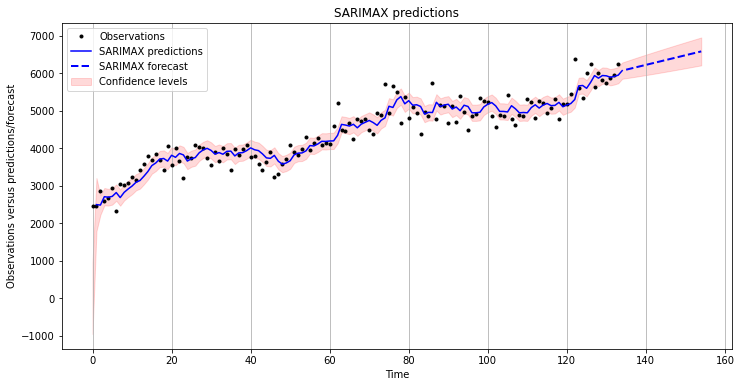

In [16]:

    
    
history = df_n2181.values
config = [(0,1,1), (0,0,0,0), 'c']
# finalizing the model

cmu.sarima_plot(history, config, 20)

## Modeling - MLP

In [18]:
# Grid search
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.2)
# model configs
cfg_list = nnu.mlp_configs()
# grid search
scores = nnu.grid_search(data, cfg_list, n_test, model_type = 'mlp', measure_type = 'rmse')  
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 8
 > 353.729
 > 442.065
 > 311.380
 > 349.043
 > 328.188
 > 310.016
 > 523.505
 > 465.521
 > 318.206
 > 333.156
 > 370.670
 > 357.028
 > 326.511
 > 341.489
 > 380.398
 > 310.598
 > 319.993
 > 309.403
 > 346.894
 > 366.736
 > 441.485
 > 335.486
 > 352.639
 > 332.807
 > 325.675
 > 326.734
 > 314.371
 > 412.837
 > 413.707
 > 338.312
> Model[[12, 50, 100, 1, 0]] 358.619
 > 466.071
 > 452.235
 > 426.358
 > 382.581
 > 433.365
 > 436.730
 > 469.874
 > 412.480
 > 511.886
 > 462.031
 > 489.983
 > 404.536
 > 436.417
 > 500.753
 > 466.326
 > 445.345
 > 412.183
 > 452.939
 > 407.910
 > 477.300
 > 407.844
 > 484.138
 > 397.388
 > 392.884
 > 421.434
 > 439.703
 > 405.516
 > 470.143
 > 430.668
 > 468.540
> Model[[12, 50, 100, 1, 12]] 442.185
 > 419.732
 > 387.851
 > 417.224
 > 424.554
 > 387.781
 > 378.300
 > 418.378
 > 383.791
 > 378.197
 > 349.804
 > 381.534
 > 424.772
 > 378.423
 > 327.943
 > 315.622
 > 403.133
 > 371.151
 > 379.084
 > 372.521
 > 350.301
 > 408.095
 > 388.955
 > 379

 > 322.090
 > 294.715
 > 319.741
 > 316.751
 > 342.753
 > 315.300
 > 322.615
 > 311.648
 > 307.277
 > 316.342
 > 332.797
 > 290.554
 > 302.816
 > 313.260
 > 309.601
 > 312.189
 > 330.943
 > 308.502
 > 300.245
 > 326.294
 > 306.538
 > 309.502
 > 309.015
 > 326.410
 > 313.793
 > 335.632
 > 338.265
 > 307.848
 > 312.178
 > 324.183
mlp: 315.993 RMSE (+/- 12.224)


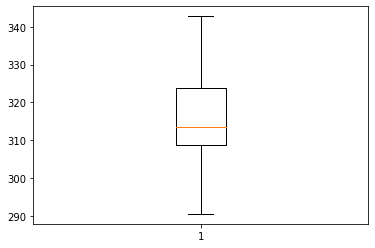

In [21]:
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.2)
# define config
config = [12, 100, 100, 150, 12]
# grid search
scores = nnu.repeat_evaluate(data, config, n_test, model_type= 'mlp', measure_type='rmse')
# summarize scores
nnu.summarize_scores('mlp', scores)

## Modeling - CNN

In [22]:
# Grid search
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.2)
# model configs
cfg_list = nnu.cnn_configs()
# grid search
scores = nnu.grid_search(data, cfg_list, n_test, model_type = 'cnn', measure_type = 'rmse')  
print('done')
# list top 10 configs
for cfg, error in scores[:3]:
    print(cfg, error)

Total configs: 8
 > 349.807
 > 383.993
 > 581.879
 > 484.040
 > 421.797
 > 448.788
 > 474.210
 > 339.387
 > 399.529
 > 380.716
 > 400.560
 > 444.243
 > 397.181
 > 363.937
 > 408.698
 > 340.874
 > 390.231
 > 394.133
 > 471.833
 > 504.464
 > 386.970
 > 358.262
 > 417.474
 > 428.076
 > 392.645
 > 346.736
 > 381.879
 > 385.558
 > 500.853
 > 496.725
> Model[[12, 64, 3, 100, 1, 0]] 415.849
 > 434.757
 > 424.021
 > 412.700
 > 443.920
 > 444.336
 > 420.242
 > 423.956
 > 417.548
 > 413.516
 > 458.624
 > 413.597
 > 433.024
 > 385.918
 > 387.178
 > 410.660
 > 395.958
 > 407.187
 > 440.733
 > 401.501
 > 464.271
 > 395.617
 > 438.836
 > 433.439
 > 410.804
 > 418.292
 > 416.134
 > 408.073
 > 410.432
 > 402.079
 > 442.807
> Model[[12, 64, 3, 100, 1, 12]] 420.339
 > 379.227
 > 393.545
 > 366.352
 > 367.614
 > 360.003
 > 355.933
 > 362.656
 > 349.908
 > 367.930
 > 369.794
 > 360.042
 > 356.994
 > 369.983
 > 351.976
 > 361.774
 > 357.749
 > 374.670
 > 348.118
 > 343.435
 > 356.400
 > 341.484
 > 354.315


 > 314.491
 > 316.071
 > 339.184
 > 308.443
 > 341.606
 > 340.531
 > 324.965
 > 327.361
 > 317.128
 > 321.682
 > 351.814
 > 336.384
 > 336.373
 > 327.972
 > 326.973
 > 345.350
 > 342.572
 > 342.611
 > 317.452
 > 326.094
 > 303.391
 > 331.331
 > 325.318
 > 316.865
 > 354.105
 > 305.421
 > 338.354
 > 326.599
 > 334.810
 > 354.189
cnn: 329.848 RMSE (+/- 13.627)


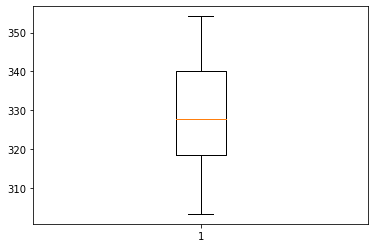

In [23]:
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.2)
# define config
config = [12, 64, 3, 100, 150, 12]
# grid search
scores = nnu.repeat_evaluate(data, config, n_test, model_type= 'cnn', measure_type='rmse')
# summarize scores
nnu.summarize_scores('cnn', scores)

## Modeling - LSTM

 > 371.251
 > 413.089
 > 363.492
 > 713.224
 > 450.464
 > 377.785
 > 395.102
 > 387.233
 > 382.580
 > 370.706
 > 386.525
 > 381.513
 > 369.398
 > 383.863
 > 379.343
 > 362.381
 > 371.211
 > 374.424
 > 362.112
 > 423.567
 > 384.651
 > 371.115
 > 398.715
 > 362.398
 > 361.029
 > 363.655
 > 359.032
 > 383.004
 > 361.869
 > 366.627
lsmt: 391.045 RMSE (+/- 63.066)


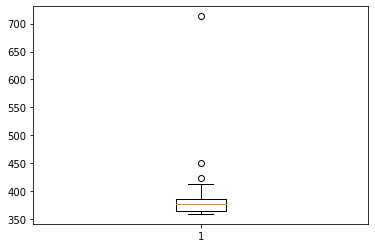

In [24]:
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.2)
# define config
# the last param is the order of differencing. This should be optimized to make the ts stationary
# the first param is the input size. This should be optimized 
config = [36, 50, 100, 100, 1]
# grid search
scores = nnu.repeat_evaluate(data, config, n_test, model_type= 'lsmt', measure_type='rmse')
# summarize scores
nnu.summarize_scores('lsmt', scores)

# Modeling - CNN-LSMT

 > 415.644
 > 409.427
 > 386.367
 > 393.813
 > 421.062
 > 403.851
 > 421.794
 > 426.159
 > 393.330
 > 422.981
 > 451.397
 > 410.302
 > 385.586
 > 429.966
 > 378.405
 > 409.847
 > 399.093
 > 381.269
 > 406.121
 > 405.342
 > 415.149
 > 408.961
 > 409.792
 > 364.664
 > 346.626
 > 386.703
 > 426.964
 > 398.645
 > 429.721
 > 399.648
cnn_lstm: 404.621 RMSE (+/- 21.003)


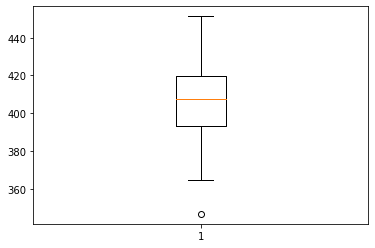

In [25]:
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.2)
# define config
config = [3, 12, 64, 3, 100, 200, 100]
# grid search
scores = nnu.repeat_evaluate(data, config, n_test, model_type= 'cnn_lstm', measure_type='rmse')
# summarize scores
nnu.summarize_scores('cnn_lstm', scores)

# Modeling - ConvLSTM

 > 385.090
 > 356.011
 > 343.405
 > 353.281
 > 377.408
 > 361.413
 > 367.299
 > 347.943
 > 390.842
 > 362.678
 > 346.303
 > 317.752
 > 334.707
 > 355.427
 > 387.263
 > 323.068
 > 437.471
 > 394.428
 > 346.760
 > 352.937
 > 353.897
 > 328.058
 > 378.693
 > 361.813
 > 347.222
 > 358.060
 > 324.104
 > 367.545
 > 373.733
 > 382.685
cnn_lstm: 360.577 RMSE (+/- 24.628)


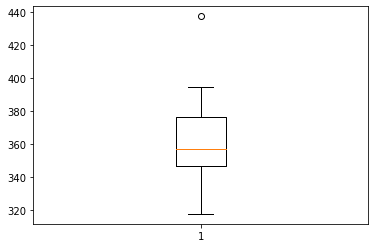

In [26]:
# define dataset
data = df_n2181.values
# data split 50%
n_test = round(len(df_n2181) * 0.2)
# define config
config = [3, 12, 256, 3, 200, 200, 100]
# grid search
scores = nnu.repeat_evaluate(data, config, n_test, model_type= 'cnn_lstm', measure_type='rmse')
# summarize scores
nnu.summarize_scores('cnn_lstm', scores)